In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op
from pytensor.tensor.type import TensorType

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp


import pyhf
pyhf.set_backend('jax')

import pymc as pm
import arviz as az

import MH_inference
import HMC_inference
import prepare_inference


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Model

In [2]:
### Simple pyhf model
model = pyhf.Model(
    {'channels': [{'name': 'singlechannel',
    'samples': [
    {'name': 'signal',
     'data': [6, 6, 10],
     'modifiers': [
         {'name': 'mu', 'type': 'normfactor', 'data': None}]},

    {'name': 'background',
     'data': [550, 550, 550]
     ,
     'modifiers': [
        ## Staterror / Normal
        {"name": "my_staterror","type": "staterror","data": [2.0, 2.0, 2.0],},
        {"name": "my_staterror1","type": "staterror","data": [2.0, 2.0, 2.0],},
        {"name": "my_staterror2","type": "staterror","data": [2.0, 2.0, 2.0],},
        ## Lumi / Normal
        # {'name': 'lumi', 'type': 'lumi', 'data': None},
        ## Correlated / Normal
        # {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [650, 560, 670], 'lo_data': [40, 40, 43]}},
        # {'name': 'corr_bkg1', 'type': 'histosys','data': {'hi_data': [650, 506, 670], 'lo_data': [400, 400, 430]}},
        # {'name': 'corr_bkg2', 'type': 'histosys','data': {'hi_data': [650, 560, 670], 'lo_data': [400, 400, 430]}},
        # ## Uncorrelated / Poisson
        {'name': 'uncorr_bkg', 'type': 'shapesys','data': [7, 8, 7.17]},
        {'name': 'uncorr_bkg1', 'type': 'shapesys','data': [7, 8, 7.17]},
        {'name': 'uncorr_bkg2', 'type': 'shapesys','data': [7, 8, 7.17]},
        {'name': 'uncorr_bkg3', 'type': 'shapesys','data': [7, 8, 7.17]},
        {'name': 'uncorr_bkg4', 'type': 'shapesys','data': [7, 8, 7.17]},
        {'name': 'uncorr_bkg5', 'type': 'shapesys','data': [7, 8, 7.17]},
        
         ]
         },    
                                 
    ]},
    ]
    ,
    "parameters": [
            {
                "name": "lumi",
                "auxdata": [1.0],
                "sigmas": [0.017],
                "bounds": [[0.915, 1.085]],
                "inits": [1.0],
            }],
        }
)

obs = model.expected_actualdata(model.config.suggested_init())

nBins = len(model.expected_actualdata(model.config.suggested_init()))
nPars = len(model.config.suggested_init())

# Prepare the priors for sampling
    # Unconstrained parameters
unconstr_dict = {
    'uncon1': {'type': 'unconstrained', 'type2': 'normal', 'input': [[25], [1]]}
    }

    # Create dictionary with all priors (unconstrained, constrained by normal and poisson)
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)

    # dictionary with keys 'model', 'obs', 'priors', 'precision'
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, precision=1, priors=prior_dict)

In [3]:
with open('SRee_SRmm_Srem.json') as serialized:
# with open('ttbar_ljets_xsec_inclusive_pruned.json') as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
model = workspace.model()

obs = workspace.data(model, include_auxdata=False)

nBins = len(model.expected_actualdata(model.config.suggested_init()))
nPars = len(model.config.suggested_init())

# Prepare the priors for sampling
    # Unconstrained parameters
unconstr_dict = {
    'uncon1': {'type': 'unconstrained', 'type2': 'normal', 'input': [[25], [1]]}
    }

    # Create dictionary with all priors (unconstrained, constrained by normal and poisson)
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)

    # dictionary with keys 'model', 'obs', 'priors', 'precision'
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, precision=1, priors=prior_dict)

## General functions

In [3]:
# Jax expected data
# @jax.jit
def processed_expData(parameters):
    return model.expected_actualdata(parameters)

# Gradient list (dn_bins/dx_1, ..., dn_bins/dx_nPars)
# @jax.jit
def vjp_expData(pars, tang_vec):
    _, back = jax.vjp(processed_expData, pars)
    return back(tang_vec)[0]

jitted_processed_expData = jax.jit(processed_expData)
jitted_vjp_expData = jax.jit(vjp_expData)


## Hamiltonian MC

### Gradient Op

In [4]:
class VJPOp(Op):

    itypes = [pt.dvector,pt.dvector]  
    otypes = [pt.dvector]

    def perform(self, node, inputs, outputs):
        (parameters, tangent_vector) = inputs
        results = jitted_vjp_expData(parameters, tangent_vector)

        if not isinstance(results, (list, tuple)):
                results = (results,)
                
        for i, r in enumerate(results):
            # outputs[i][0] = np.asarray(r, dtype="float64")
            outputs[i][0] = np.asarray(r)

vjp_op = VJPOp()

## Non Gradient Op

In [5]:
class ExpDataOp(Op):

    itypes = [pt.dvector]  
    otypes = [pt.dvector]

    def perform(self, node, inputs, outputs):
        (parameters, ) = inputs
        results = jitted_processed_expData(parameters)

        if len(outputs) == 1:
                outputs[0][0] = np.asarray(results)
                return
        for i, r in enumerate(results):
                # outputs[i][0] = np.asarray(r, dtype="float64")
                outputs[i][0] = np.asarray(r)

    def grad(self, inputs, output_gradients):
        (parameters,) = inputs
        (tangent_vector,) = output_gradients
        return [vjp_op(parameters, tangent_vector)]

        
expData_op = ExpDataOp()

### Sampling

In [6]:
with pm.Model():
    pars = prepare_inference.priors2pymc(prepared_model)
    
    parsD = pm.Deterministic('pars', pars)
    # ExpData = pm.Poisson("ExpData", mu=expData_op(pars), observed=obs)
    ExpData = pm.Normal("ExpData", mu=expData_op(pars), sigma = float(obs[0])**(0.5), observed=obs)
    
    # step = pm.HamiltonianMC()
    post_data = pm.sample(150, chains=2)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(150)

Only 150 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Mu

Sampling 2 chains for 1_000 tune and 150 draw iterations (2_000 + 300 draws total) took 7 seconds.


ValueError: different number of dimensions on data and dims: 3 vs 2

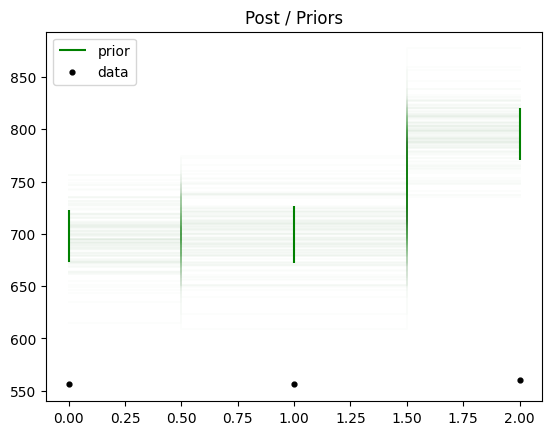

In [9]:
# Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.ExpData[0].T, alpha = 0.01, c = 'green', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'green', label='prior');

# Posterior
# plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.ExpData[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
# plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'steelblue', label='posterior')

# Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f'Post / Priors')

# plt.savefig('NUTS_updating')
plt.show()

array([[<AxesSubplot: title={'center': 'Unconstrained'}>,
        <AxesSubplot: title={'center': 'Unconstrained'}>]], dtype=object)

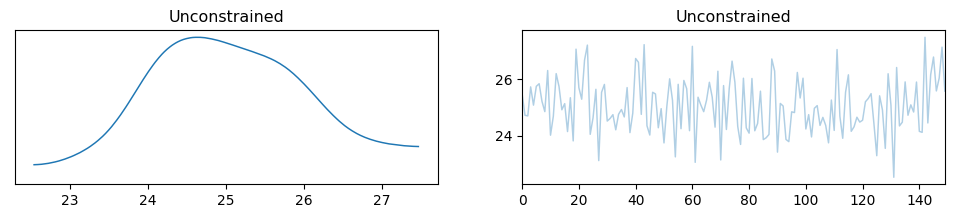

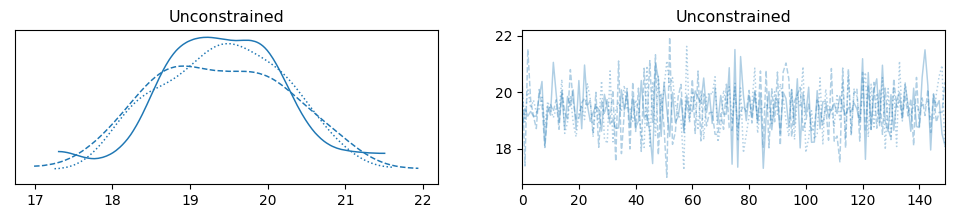

In [8]:
az.plot_trace(prior_pred.prior, var_names='Unconstrained')
az.plot_trace(post_data.posterior, var_names='Unconstrained')

In [ ]:
fig = corner.corner(prior_pred.prior.Normals[0], hist_kwargs={'density': True}, color='green');
fig = corner.corner(post_data.posterior.Normals[0], fig = fig, color = 'steelblue', hist_kwargs={'density': True});